In [30]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven


In [31]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "H"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


/var/folders/fp/29v7pg1d4n73gv7rz4jgc0s80000gn/T/ipykernel_15539/1227359451.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  times = pd.date_range(


### Ny kode

In [32]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [33]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.185*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB * np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [34]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

NameError: name 'theta_panel' is not defined

In [ ]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [ ]:
energi_Wh = energi / 3600
energi_Wh

0.03839488067883965

In [ ]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=3600)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[1.9477088162081015,
 1.9701792007550174,
 1.9921617558909757,
 2.013537479257585,
 2.0342998596024375,
 2.05444257250335,
 2.0739594822948457,
 2.0928446439371378,
 2.1110923048270447,
 2.128696906550292,
 2.1463334634184994,
 2.1636769412342782,
 2.1803613420937484,
 2.196381583766782,
 2.2117327863325746,
 2.2264102736661124,
 2.2404095748625714,
 2.2537264255991936,
 2.266356769434239,
 2.2782967590426244,
 2.2895427573878484,
 2.3000913388298736,
 2.3099392901686056,
 2.319083611622669,
 2.3275215177431634,
 2.335250438262147,
 2.3422680188755565,
 2.3485721219603573,
 2.35416082722568,
 2.359032432297761,
 2.3631854532385037,
 2.3666186249974994,
 2.3693309017973707,
 2.371321457452331,
 2.3725896856198445,
 2.3731351999853256,
 2.3729578343798146,
 2.372057642830592,
 2.3704348995447257,
 2.3680900988255402,
 2.365023954922047,
 2.361237401811384,
 2.3567315929143082,
 2.35150790074386,
 2.345573904851332,
 2.340369426301825,
 2.334452048553399,
 2.327823574096639,
 2.3204860220

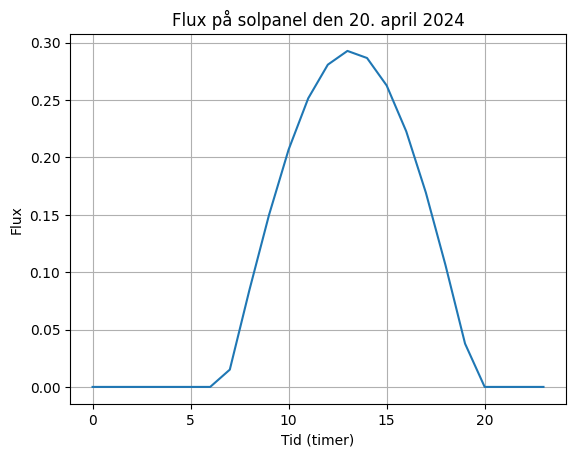

In [ ]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

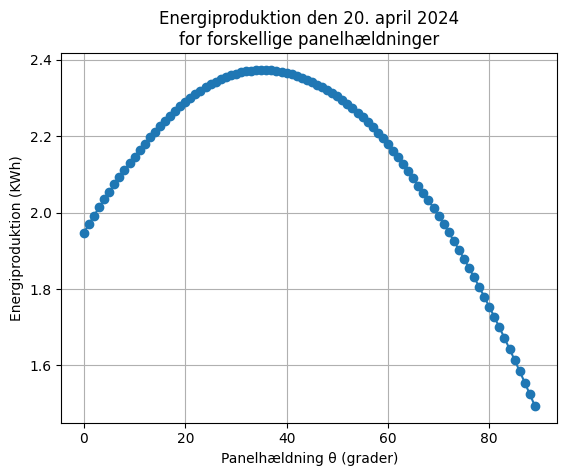

35

In [ ]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (KWh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()
np.argmax(wh_energier)

In [ ]:
# henter pris data
import requests
import pandas as pd

endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": "2024-01-01T00:00",
    "end": "2024-12-31T23:00",
    "filter": '{"PriceArea":["DK2"]}'  # <-- fixed JSON string
}

response = requests.get(endpoint, params=params)
data = response.json()
df = pd.DataFrame(data['records'])
# Konverter evt. enheder (øre/kroner, kWh/J/MJ) hvis nødvendigt.
# følgende er forkert, dvs. tidsrumer ganget med forskudte.
print(df)
energi = integrate.simpson(flux_array, dx=3600)
energi

                  HourUTC               HourDK PriceArea  SpotPriceDKK  \
0     2024-12-31T21:00:00  2024-12-31T22:00:00       DK2     59.529999   
1     2024-12-31T20:00:00  2024-12-31T21:00:00       DK2    117.120003   
2     2024-12-31T19:00:00  2024-12-31T20:00:00       DK2    168.509995   
3     2024-12-31T18:00:00  2024-12-31T19:00:00       DK2    180.820007   
4     2024-12-31T17:00:00  2024-12-31T18:00:00       DK2    193.729996   
...                   ...                  ...       ...           ...   
8778  2024-01-01T03:00:00  2024-01-01T04:00:00       DK2    178.990005   
8779  2024-01-01T02:00:00  2024-01-01T03:00:00       DK2    182.490005   
8780  2024-01-01T01:00:00  2024-01-01T02:00:00       DK2    198.740005   
8781  2024-01-01T00:00:00  2024-01-01T01:00:00       DK2    212.160004   
8782  2023-12-31T23:00:00  2024-01-01T00:00:00       DK2    217.160004   

      SpotPriceEUR  
0         7.980000  
1        15.700000  
2        22.590000  
3        24.240000  
4     

5379.092896115253

In [ ]:
# nyt solpos object, der paser til mængden fra tidligere, men med gennemsnit over timer, og mangler sidste time af 12-31, 
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 22:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

solpos.zenith.shape

times.shape, 366*24-1




((8783,), 8783)

In [ ]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    WnLB = 0.185*1.63*550 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = WnLB * u_s.T@u_p
    return np.maximum(dot_products, 0)

# solar_panel_projection(np.array([1,2,3]), np.array([1,3,3]), np.array([1]), np.array([1]))

In [ ]:
# Flux array constructor
for zenitha in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(zenitha)
    phi_panel = np.deg2rad(1)
    for azimutha in range(0, 360):
        flux_array
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
theta_panel, phi_panel = np.deg2rad(50), np.deg2rad(180)
theta_sol, phi_sol = np.deg2rad(solpos.zenith.values), np.deg2rad(solpos.azimuth.values)

energier = []
wh_energier = []

flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

print(flux_array[18:1000])
energi = integrate.simpson(flux_array, dx=3600)
print(energi)
energier.append(energi)
wh_energier.append(energi/3600)

print(energier)


[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  94.33871679 120.43396857 137.90817168 145.57068373 142.89910321
 130.07490336 107.97110457   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          94.19710358
 120.37094676 137.92964653 145.6767606  143.08408124 130.32766827
 108.27589336   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          94.06491694 120.31796807
 137.96122265 145.79243439 143.27762411 130.58750933 108.58591563
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0. 

In [ ]:
theta_sol.shape

(8783,)

In [ ]:
len(energier)

1

In [ ]:
print(theta_sol.shape)

(8783,)


Der er blevet udregnet for 8782 timer 2024-01-01 til 2024-12-31.
Data matchede ikke i størrelse, dimensioner med manglenede data er erstattet med 0'er.
  Calculating for Tilt Angle: 0° (1/91)
  Calculating for Tilt Angle: 9° (10/91)
  Calculating for Tilt Angle: 19° (20/91)
  Calculating for Tilt Angle: 29° (30/91)
  Calculating for Tilt Angle: 39° (40/91)
  Calculating for Tilt Angle: 49° (50/91)
  Calculating for Tilt Angle: 59° (60/91)
  Calculating for Tilt Angle: 69° (70/91)
  Calculating for Tilt Angle: 79° (80/91)
  Calculating for Tilt Angle: 89° (90/91)
Calculation finished.


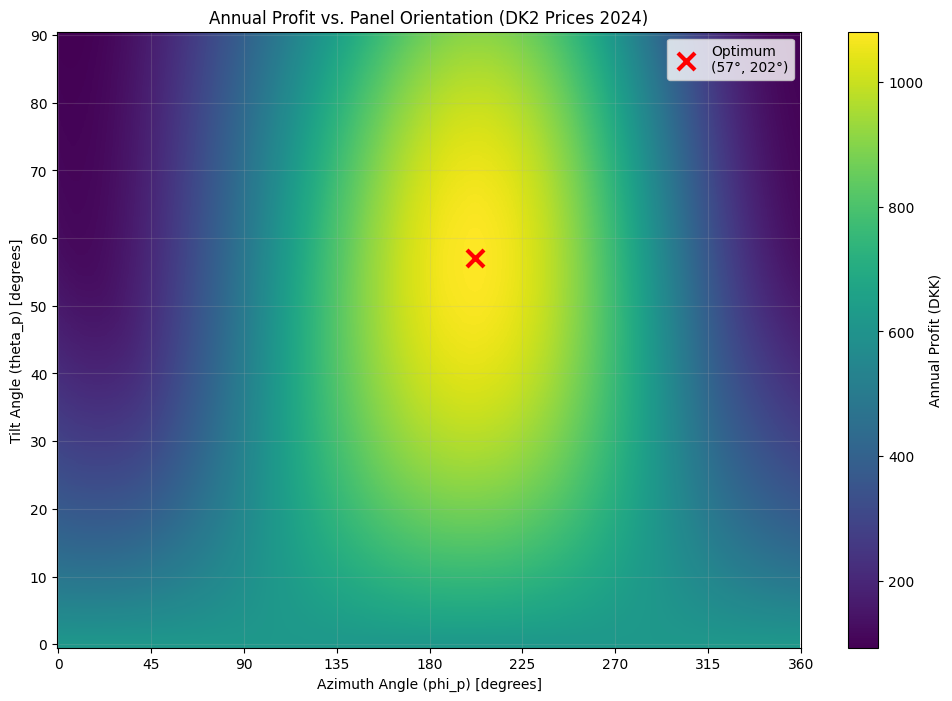

Heatmap generated.


In [45]:

# redefinere globale variabler, og constructors for at sikre functionalitet/brug af korrekte data,
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h" 

site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)

# 
times_hourly = pd.date_range(
    start=start_dato + " 00:00:00",
    end=slut_dato + " 21:00:00", # Inclusive endpoint for the last hour
    freq=delta_tid,
    tz=tidszone
)
print(f"Der er blevet udregnet for {len(times_hourly)} timer {start_dato} til {slut_dato}.")
hourly_price_DKK_per_kWh_aligned = None # Initialize

solpos_hourly = site.get_solarposition(times_hourly)
theta_sol_hourly = np.deg2rad(solpos_hourly.zenith.values)
phi_sol_hourly = np.deg2rad(solpos_hourly.azimuth.values)


import requests
import pandas as pd

endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": "2024-01-01T00:00",
    "end": "2024-12-31T23:00",
    "filter": '{"PriceArea":["DK2"]}' 
}
# {"HourUTC":"2025-05-01T21:00:00","HourDK":"2025-05-01T23:00:00","PriceArea":"DE","SpotPriceDKK":650.079545,"SpotPriceEUR":87.099998}
response = requests.get(endpoint, params=params)
data = response.json()
df_prices = pd.DataFrame(data['records'])
df_prices['HourDK'] = pd.to_datetime(df_prices['HourDK'])
df_prices = df_prices.set_index('HourDK')
df_prices = df_prices[~df_prices.index.duplicated(keep='first')]
hourly_price_DKK_per_kWh = df_prices['SpotPriceDKK'] / 100.0
hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh.reindex(times_hourly).ffill().bfill()



if len(hourly_price_DKK_per_kWh_aligned) != len(times_hourly):
         hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh_aligned.reindex(times_hourly).ffill().bfill()
print("Data matchede ikke i størrelse, dimensioner med manglenede data er erstattet med 0'er.")

# Sol og panel vektorer til projektionen, som bruges til at finde componenten af irradians der er arbedjsom i panelet. 
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    SnLB = 0.185 * 1.63 * 280 # S er solens Irradiance, n er panel effektivitet, LB(længde og bredde) er arealet af panelet.
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])
    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = SnLB * u_s.T@u_p
    return np.maximum(dot_products, 0)
# Værdi af strøm generet, som er den integrerede værdi af fluxen over tid, ganget med prisen på strømmen.
def calculate_annual_profit(theta_panel_rad, phi_panel_rad, theta_sol, phi_sol, price_per_kwh):
    hourly_power_W = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel_rad, phi_panel_rad),
        0.0
    )
    hourly_energy_kWh = hourly_power_W / 1000.0
    hourly_value_DKK = hourly_energy_kWh * price_per_kwh.values
    total_value_DKK = np.sum(hourly_value_DKK)
    return total_value_DKK
# Definitionsmængden i grader
tilt_angles_deg = np.arange(0, 91)  # 0 to 90 degrees inclusive
azimuth_angles_deg = np.arange(0, 360) # 0 to 359 degrees inclusive

# Initialize results array
annual_profits = np.zeros((len(tilt_angles_deg), len(azimuth_angles_deg)))

# Nested for loop til beregning af profit for hver kombination af hældning og azimuth, for sammenligning.
for i, theta_p_deg in enumerate(tilt_angles_deg):
    theta_p_rad = np.deg2rad(theta_p_deg)

    # Print progress every 10 tilt angles
    if (i + 1) % 10 == 0 or i == 0:
         print(f"  Calculating for Tilt Angle: {theta_p_deg}° ({i+1}/{len(tilt_angles_deg)})")

    for j, phi_p_deg in enumerate(azimuth_angles_deg):
        phi_p_rad = np.deg2rad(phi_p_deg)

        # annual profit
        profit = calculate_annual_profit(
            theta_p_rad,
            phi_p_rad,
            theta_sol_hourly,
            phi_sol_hourly,
            hourly_price_DKK_per_kWh # Use the aligned price Series
        )
        annual_profits[i, j] = profit

print("Calculation finished.")

# --- 7. Find and Report the Optimal Combination ---

# Find the maximum profit value
max_profit = np.max(annual_profits)

# Find the indices (row, column) of the maximum value
max_indices = np.unravel_index(np.argmax(annual_profits), annual_profits.shape)
optimal_tilt_index = max_indices[0]
optimal_azimuth_index = max_indices[1]

# Get the corresponding optimal angles in degrees
optimal_tilt_deg = tilt_angles_deg[optimal_tilt_index]
optimal_azimuth_deg = azimuth_angles_deg[optimal_azimuth_index]

# data vizualization
plt.figure(figsize=(12, 8))
im = plt.imshow(annual_profits, aspect='auto', origin='lower',
                extent=[azimuth_angles_deg[0]-0.5, azimuth_angles_deg[-1]+0.5,
                        tilt_angles_deg[0]-0.5, tilt_angles_deg[-1]+0.5],
                cmap='viridis')
plt.colorbar(im, label='Annual Profit (DKK)')
plt.xlabel("Azimuth Angle (phi_p) [degrees]")
plt.ylabel("Tilt Angle (theta_p) [degrees]")
plt.title("Annual Profit vs. Panel Orientation (DK2 Prices 2024)")
plt.scatter([optimal_azimuth_deg], [optimal_tilt_deg], color='red', marker='x', s=150, linewidth=3, label=f'Optimum\n({optimal_tilt_deg}°, {optimal_azimuth_deg}°)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.xticks(np.arange(0, 361, 45))
plt.yticks(np.arange(0, 91, 10))
plt.show()
print("Heatmap generated.")

In [78]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pvlib.location import Location

# redefinere globale variabler, og constructors for at sikre functionalitet/brug af korrekte data,
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h"

site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)

#
times_hourly = pd.date_range(
    start=start_dato + " 00:00:00",
    end=slut_dato + " 21:00:00",  # Inclusive endpoint for the last hour
    freq=delta_tid,
    tz=tidszone
)
print(f"Der er blevet udregnet for {len(times_hourly)} timer {start_dato} til {slut_dato}.")
hourly_price_DKK_per_kWh_aligned = None  # Initialize

solpos_hourly = site.get_solarposition(times_hourly)
theta_sol_hourly = np.deg2rad(solpos_hourly.zenith.values)
phi_sol_hourly = np.deg2rad(solpos_hourly.azimuth.values)


endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": "2024-01-01T00:00",
    "end": "2024-12-31T23:00",
    "filter": '{"PriceArea":["DK2"]}'
}
# {"HourUTC":"2025-05-01T21:00:00","HourDK":"2025-05-01T23:00:00","PriceArea":"DE","SpotPriceDKK":650.079545,"SpotPriceEUR":87.099998}
response = requests.get(endpoint, params=params)
data = response.json()
df_prices = pd.DataFrame(data['records'])
df_prices['HourDK'] = pd.to_datetime(df_prices['HourDK'])
df_prices = df_prices.set_index('HourDK')
df_prices = df_prices[~df_prices.index.duplicated(keep='first')]
hourly_price_DKK_per_kWh = df_prices['SpotPriceDKK'] / 100.0
hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh.reindex(times_hourly).ffill().bfill()


if len(hourly_price_DKK_per_kWh_aligned) != len(times_hourly):
    hourly_price_DKK_per_kWh_aligned = hourly_price_DKK_per_kWh_aligned.reindex(times_hourly).ffill().bfill()
print("Data matchede ikke i størrelse, dimensioner med manglenede data er erstattet med 0'er.")

# Sol og panel vektorer til projektionen, som bruges til at finde componenten af irradians der er arbedjsom i panelet.
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    SnLB = 0.185 * 1.63 * 280  # S er solens Irradiance, n er panel effektivitet, LB(længde og bredde) er arealet af panelet.
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])
    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = SnLB * np.sum(u_s * u_p, axis=0)
    return np.maximum(dot_products, 0)

# Værdi af strøm generet, som er den integrerede værdi af fluxen over tid, ganget med prisen på strømmen.
def calculate_annual_profit_vectorized(theta_panel_rad, phi_panel_rad, theta_sol, phi_sol, price_per_kwh):
    hourly_power_W = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol[np.newaxis, :], phi_sol[np.newaxis, :], theta_panel_rad[:, np.newaxis], phi_panel_rad[:, np.newaxis]),
        0.0
    )
    hourly_energy_kWh = hourly_power_W / 1000.0
    hourly_value_DKK = hourly_energy_kWh * price_per_kwh.values
    total_value_DKK = np.sum(hourly_value_DKK, axis=1)
    return total_value_DKK

# Definitionsmængden i grader
tilt_angles_deg = np.arange(0, 91)  # 0 to 90 degrees inclusive
azimuth_angles_deg = np.arange(0, 360)  # 0 to 359 degrees inclusive

# Convert to radians
tilt_angles_rad = np.deg2rad(tilt_angles_deg)
azimuth_angles_rad = np.deg2rad(azimuth_angles_deg)

# Create meshgrids for broadcasting
theta_panel_rad_grid, phi_panel_rad_grid = np.meshgrid(tilt_angles_rad, azimuth_angles_rad)
theta_panel_rad_flat = theta_panel_rad_grid.flatten()
phi_panel_rad_flat = phi_panel_rad_grid.flatten()

print("Calculating annual profit using broadcasting...")
annual_profits_flat = calculate_annual_profit_vectorized(
    theta_panel_rad_flat,
    phi_panel_rad_flat,
    theta_sol_hourly,
    phi_sol_hourly,
    hourly_price_DKK_per_kWh_aligned
)
print("Calculation finished.")

# Reshape the result to the original grid shape
annual_profits = annual_profits_flat.reshape((len(azimuth_angles_deg), len(tilt_angles_deg))).T

# --- 7. Find and Report the Optimal Combination ---

# Find the maximum profit value
max_profit = np.max(annual_profits)

# Find the indices (row, column) of the maximum value
max_indices = np.unravel_index(np.argmax(annual_profits), annual_profits.shape)
optimal_tilt_index = max_indices[0]
optimal_azimuth_index = max_indices[1]

# Get the corresponding optimal angles in degrees
optimal_tilt_deg = tilt_angles_deg[optimal_tilt_index]
optimal_azimuth_deg = azimuth_angles_deg[optimal_azimuth_index]

# data vizualization
plt.figure(figsize=(12, 8))
im = plt.imshow(annual_profits, aspect='auto', origin='lower',
                extent=[azimuth_angles_deg[0] - 0.5, azimuth_angles_deg[-1] + 0.5,
                        tilt_angles_deg[0] - 0.5, tilt_angles_deg[-1] + 0.5],
                cmap='viridis')
plt.colorbar(im, label='Annual Profit (DKK)')
plt.xlabel("Azimuth Angle (phi_p) [degrees]")
plt.ylabel("Tilt Angle (theta_p) [degrees]")
plt.title("Annual Profit vs. Panel Orientation (DK2 Prices 2024)")
plt.scatter([optimal_azimuth_deg], [optimal_tilt_deg], color='red', marker='x', s=150, linewidth=3,
            label=f'Optimum\n({optimal_tilt_deg}°, {optimal_azimuth_deg}°)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.xticks(np.arange(0, 361, 45))
plt.yticks(np.arange(0, 91, 10))
plt.show()
print("Heatmap generated.")

Der er blevet udregnet for 8782 timer 2024-01-01 til 2024-12-31.
Data matchede ikke i størrelse, dimensioner med manglenede data er erstattet med 0'er.
Calculating annual profit using broadcasting...


: 

In [ ]:

hourly_price_DKK_per_kWh_aligned.duplicated()

HourDK
2024-12-31 22:00:00    False
2024-12-31 21:00:00    False
2024-12-31 20:00:00    False
2024-12-31 19:00:00    False
2024-12-31 18:00:00    False
                       ...  
2024-01-01 04:00:00    False
2024-01-01 03:00:00    False
2024-01-01 02:00:00    False
2024-01-01 01:00:00    False
2024-01-01 00:00:00    False
Name: SpotPriceDKK, Length: 8782, dtype: bool

In [73]:
duplicates = hourly_price_DKK_per_kWh_aligned[hourly_price_DKK_per_kWh_aligned.duplicated()]
print(duplicates)

HourDK
2024-12-30 07:00:00    1.0287
2024-12-30 05:00:00    0.2678
2024-12-30 04:00:00    0.2678
2024-12-30 02:00:00    0.2678
2024-12-30 00:00:00    0.2678
                        ...  
2024-01-02 16:00:00    6.0726
2024-01-02 12:00:00    5.8266
2024-01-02 01:00:00    2.5018
2024-01-01 23:00:00    2.8328
2024-01-01 06:00:00    1.1831
Name: SpotPriceDKK, Length: 706, dtype: float64


In [76]:
duplicate_counts = hourly_price_DKK_per_kWh_aligned[hourly_price_DKK_per_kWh_aligned.duplicated()]
duplicate_counts = duplicate_counts.value_counts().sort_values(ascending=False)
print(duplicate_counts)

SpotPriceDKK
 0.0000    44
 0.0007    20
-0.0007    13
-0.0015    10
 0.0015     8
           ..
 4.8458     1
 5.4594     1
 6.1855     1
 4.8451     1
 1.1831     1
Name: count, Length: 502, dtype: int64


In [77]:
duplicate_counts = hourly_price_DKK_per_kWh_aligned.index[hourly_price_DKK_per_kWh_aligned.index.duplicated()]
duplicate_counts = pd.Series(duplicate_counts).value_counts().sort_values(ascending=False)
print(duplicate_counts)

Series([], Name: count, dtype: int64)


In [68]:
times_hourly

DatetimeIndex(['2024-01-01 00:00:00+01:00', '2024-01-01 01:00:00+01:00',
               '2024-01-01 02:00:00+01:00', '2024-01-01 03:00:00+01:00',
               '2024-01-01 04:00:00+01:00', '2024-01-01 05:00:00+01:00',
               '2024-01-01 06:00:00+01:00', '2024-01-01 07:00:00+01:00',
               '2024-01-01 08:00:00+01:00', '2024-01-01 09:00:00+01:00',
               ...
               '2024-12-31 12:00:00+01:00', '2024-12-31 13:00:00+01:00',
               '2024-12-31 14:00:00+01:00', '2024-12-31 15:00:00+01:00',
               '2024-12-31 16:00:00+01:00', '2024-12-31 17:00:00+01:00',
               '2024-12-31 18:00:00+01:00', '2024-12-31 19:00:00+01:00',
               '2024-12-31 20:00:00+01:00', '2024-12-31 21:00:00+01:00'],
              dtype='datetime64[ns, Europe/Copenhagen]', length=8782, freq='h')